In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_curve(start=0, end=10, increment=0.1, lower_band=1, upper_band=5, max_amplitude=2):
    """
    Generate a set of points representing a band-limited curve that passes through (0,0).
    
    Args:
    start (float): Start of the domain (default: 0)
    end (float): End of the domain (default: 10)
    increment (float): Step size between points (default: 0.1)
    lower_band (float): Lower frequency band limit in Hz (default: 1)
    upper_band (float): Upper frequency band limit in Hz (default: 5)
    max_amplitude (float): Maximum amplitude of the curve (default: 2)
    
    Returns:
    tuple: Two arrays (x, y) representing the points of the curve
    """
    x = np.arange(start, end + increment, increment)
    y = np.zeros_like(x)
    
    # Generate random frequencies within the band limits
    num_frequencies = np.random.randint(3, 10)
    frequencies = np.random.uniform(lower_band, upper_band, num_frequencies)
    
    # Generate random amplitudes for each frequency component
    amplitudes = np.random.uniform(0.1, 1, num_frequencies)
    
    # Use cosine instead of sine to ensure y(0) = 0
    for freq, amp in zip(frequencies, amplitudes):
        y += amp * (np.cos(2 * np.pi * freq * x) - 1)
    
    # Normalize the curve to the desired maximum amplitude
    y_max = np.max(np.abs(y))
    if y_max > 0:
        y *= (max_amplitude / y_max)
    
    return x, y

In [3]:
def plot_curve(x, y, title="Band-Limited Curve"):
    """
    Plot the generated curve.
    
    Args:
    x (array): x-coordinates of the curve
    y (array): y-coordinates of the curve
    title (str): Title of the plot (default: "Band-Limited Curve")
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()


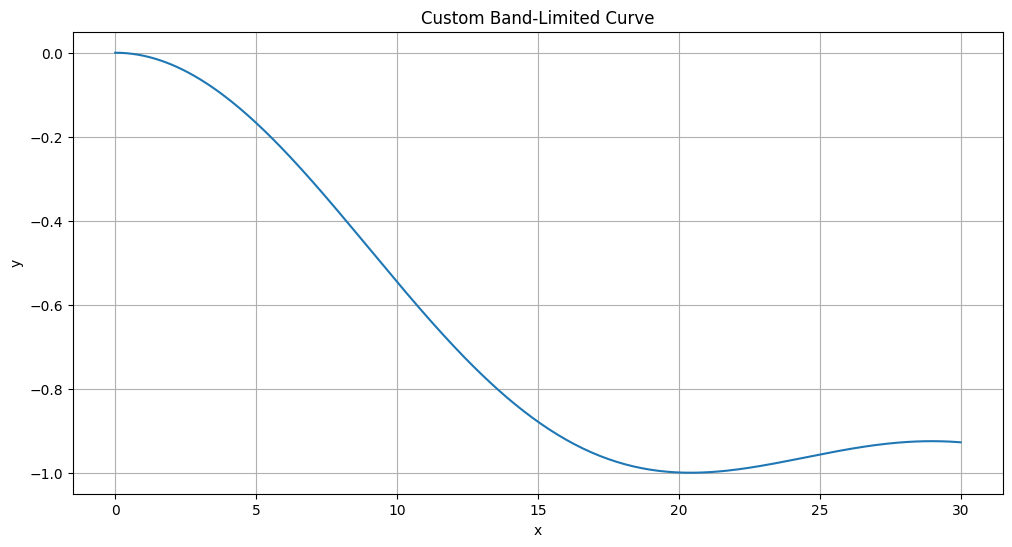

In [4]:

# Specifying custom parameters including max amplitude
x, y = generate_curve(start=0, end=30, increment=0.1, lower_band=0, upper_band=1/30, max_amplitude=1)


plot_curve(x, y, title="Custom Band-Limited Curve")

In [5]:
import numpy as np
from scipy import interpolate

def curve_tangents(x, y, n):
    """
    Calculate tangents at n points along a curve defined by x and y coordinates.
    
    Args:
    x (array): x-coordinates of the curve
    y (array): y-coordinates of the curve
    n (int): Number of points to sample
    
    Returns:
    tuple: Two arrays (sample_x, tangents) where sample_x are the x positions
           and tangents are the slopes at those positions
    """
    # Create a function to interpolate the curve
    f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')
    
    # Create sample points
    sample_x = np.linspace(x[0], x[-1], n)
    
    # Calculate tangents using central difference method
    h = (x[-1] - x[0]) / (len(x) * 1000)  # Adaptive step size
    
    # Use forward difference for the first point, backward difference for the last point
    tangents = np.zeros(n)
    tangents[1:-1] = (f(sample_x[1:-1] + h) - f(sample_x[1:-1] - h)) / (2 * h)
    tangents[0] = (f(sample_x[0] + h) - f(sample_x[0])) / h
    tangents[-1] = (f(sample_x[-1]) - f(sample_x[-1] - h)) / h
    
    return sample_x, tangents




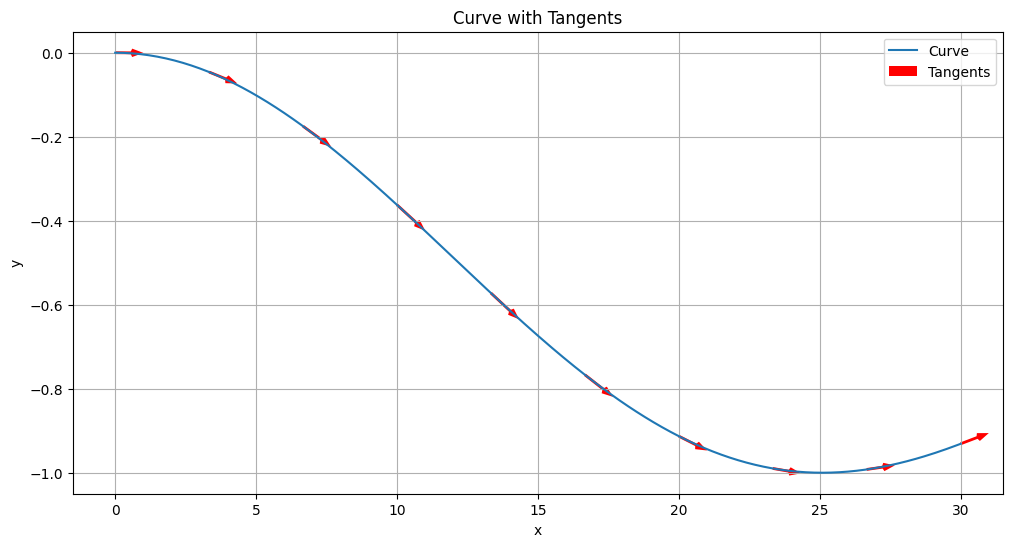

In [6]:
# Example usage:
x, y = generate_curve(start=0, end=30, increment=0.1, lower_band=0, upper_band=1/30, max_amplitude=1)
sample_x, tangents = curve_tangents(x, y, 10)

# Create interpolation function for plotting
f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Curve')
plt.quiver(sample_x, f(sample_x), np.ones_like(sample_x), tangents, 
           angles='xy', scale_units='xy', scale=1, color='r', width=0.003, 
           headwidth=3, headlength=4, label='Tangents')
plt.legend()
plt.title('Curve with Tangents')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [7]:
import numpy as np
from scipy.integrate import cumtrapz

def regenerate_curve(x, t):
    """
    Reconstruct a curve from x positions and tangents, assuming y(0) = 0.
    
    Args:
    x (array): x-coordinates
    t (array): tangents at corresponding x-coordinates
    
    Returns:
    tuple: Two arrays (x, y) representing the reconstructed curve
    """
    # Ensure x starts from 0
    if x[0] != 0:
        x = np.concatenate(([0], x))
        t = np.concatenate(([0], t))  # Assume tangent at x=0 is 0
    
    # Integrate tangents to get y values
    y = cumtrapz(t, x, initial=0)
    
    return x, y

C:\Users\Daniel\AppData\Local\Temp\ipykernel_7120\4106159034.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  y = cumtrapz(t, x, initial=0)


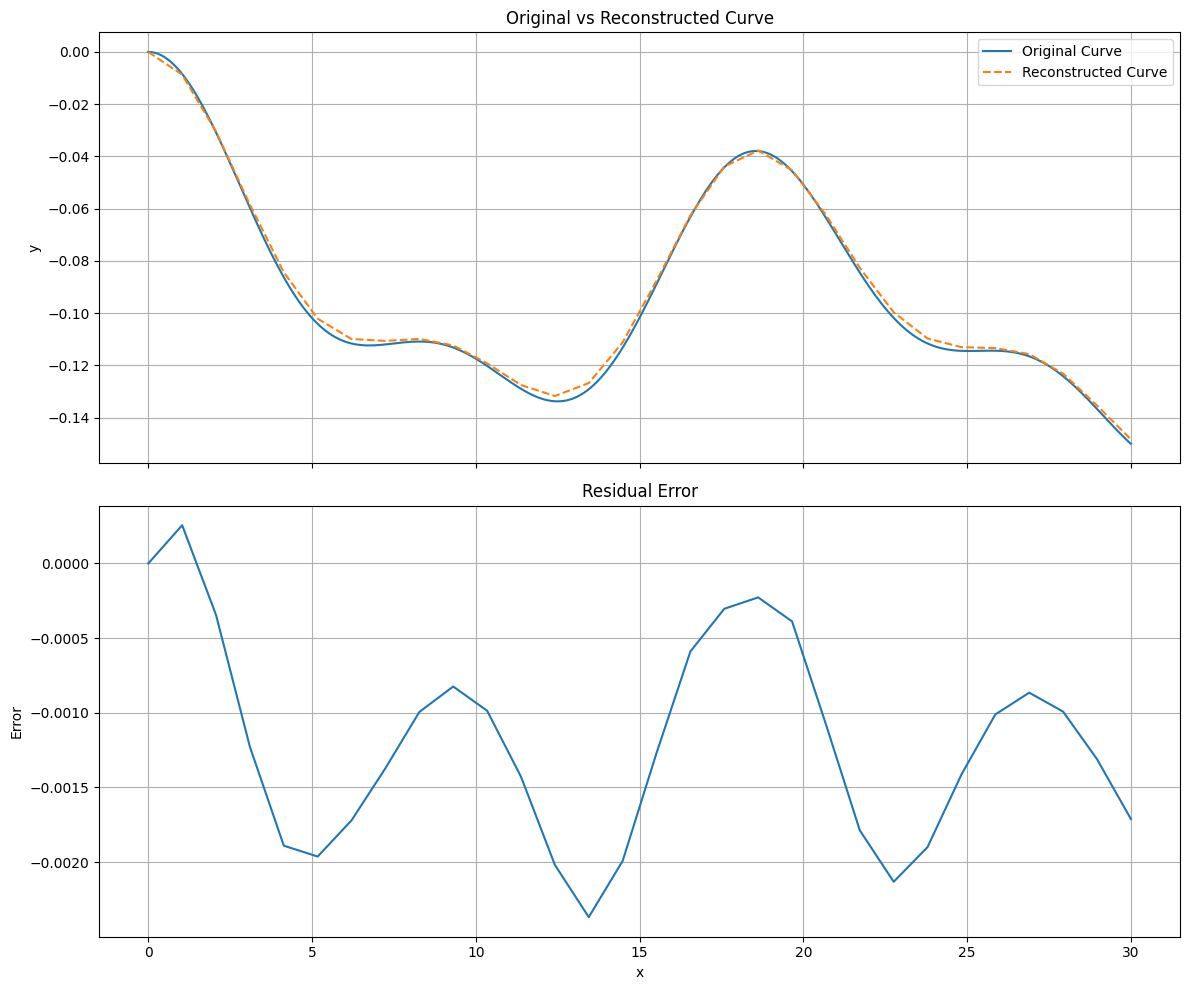

Maximum absolute error: 0.002368
Mean absolute error: 0.001212
Root mean square error: 0.001372


In [9]:
borehole_length = 30
inflection_frequency = 4
deflection_max = 0.15
ots_nodes = 30

x, y = generate_curve(start=0, end=borehole_length, increment=0.1, lower_band=0, upper_band=inflection_frequency/borehole_length, max_amplitude=deflection_max)
sample_x, tangents = curve_tangents(x, y, ots_nodes)
reconstructed_x, reconstructed_y = regenerate_curve(sample_x, tangents)

# Create interpolation function for the original curve
f_original = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')

# Calculate residual error
y_original_at_sample = f_original(reconstructed_x)
residual_error = y_original_at_sample - reconstructed_y

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot original and reconstructed curves
ax1.plot(x, y, label='Original Curve')
ax1.plot(reconstructed_x, reconstructed_y, '--', label='Reconstructed Curve')
ax1.legend()
ax1.set_title('Original vs Reconstructed Curve')
ax1.set_ylabel('y')
ax1.grid(True)

# Plot residual error
ax2.plot(reconstructed_x, residual_error)
ax2.set_title('Residual Error')
ax2.set_xlabel('x')
ax2.set_ylabel('Error')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics about the error
print(f"Maximum absolute error: {np.max(np.abs(residual_error)):.6f}")
print(f"Mean absolute error: {np.mean(np.abs(residual_error)):.6f}")
print(f"Root mean square error: {np.sqrt(np.mean(residual_error**2)):.6f}")

In [8]:
jupyter nbextension enable --py widgetsnbextension

SyntaxError: invalid syntax (2269694994.py, line 1)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
import ipywidgets as widgets
from IPython.display import display

# Assuming generate_curve, curve_tangents, and regenerate_curve functions are already defined

def update_plots(borehole_length, inflection_frequency, deflection_max, ots_nodes):
    x, y = generate_curve(start=0, end=borehole_length, increment=0.1, lower_band=0, upper_band=inflection_frequency/borehole_length, max_amplitude=deflection_max)
    sample_x, tangents = curve_tangents(x, y, ots_nodes)
    reconstructed_x, reconstructed_y = regenerate_curve(sample_x, tangents)

    f_original = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')
    y_original_at_sample = f_original(reconstructed_x)
    residual_error = y_original_at_sample - reconstructed_y

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot original and reconstructed curves
    ax1.plot(x, y, label='Original Curve')
    ax1.plot(reconstructed_x, reconstructed_y, '--', label='Reconstructed Curve')
    
    # Plot tangent locations as points
    ax1.scatter(sample_x, f_original(sample_x), color='r', s=30, label='Tangent Points')
    
    ax1.legend()
    ax1.set_title('Original vs Reconstructed Curve (with Tangent Points)')
    ax1.set_ylabel('y')
    ax1.grid(True)

    # Plot residual error
    ax2.plot(reconstructed_x, residual_error)
    ax2.set_title('Residual Error')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Error')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    max_error = np.max(np.abs(residual_error))
    mean_error = np.mean(np.abs(residual_error))
    rms_error = np.sqrt(np.mean(residual_error**2))

    print(f"Maximum absolute error: {max_error:.6f}")
    print(f"Mean absolute error: {mean_error:.6f}")
    print(f"Root mean square error: {rms_error:.6f}")

# Create widgets
borehole_length_slider = widgets.FloatSlider(value=30, min=5, max=50, step=1, description='Borehole Length (m):')
inflection_frequency_slider = widgets.FloatSlider(value=4, min=1, max=10, step=0.5, description='Inflection Frequency:')
deflection_max_slider = widgets.FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='Max Deflection (m):')
ots_nodes_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='OTS Nodes:')

# Create interactive output
interactive_plot = widgets.interactive(update_plots, 
                                       borehole_length=borehole_length_slider,
                                       inflection_frequency=inflection_frequency_slider,
                                       deflection_max=deflection_max_slider,
                                       ots_nodes=ots_nodes_slider)

# Display the interactive widget
display(interactive_plot)

interactive(children=(FloatSlider(value=30.0, description='Borehole Length (m):', max=50.0, min=5.0, step=1.0)…